In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
sns.set_style('ticks')
import scipy
from scipy import sparse, io
import h5py
import re
import time
import sklearn
import sys
import statsmodels
import statsmodels.api as sm
import sklearn.ensemble

/Users/atray/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
/Users/atray/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [17]:
outputpath='CHANGE THIS TO OUTPUT PATH'
path2data='CHANGE THIS TO DATA PATH'
#threshold on maximum tolerable false positive rate for random forest filter
fpr_threshold=0.02

In [4]:
#read, label, and concatenate human and mouse data
Th=pd.read_csv(path2data+'SpeciesMix_HundredSTAMP_bq10_star_HUMAN_auto_molBC.txt.gz',sep='\t')
Tm=pd.read_csv(path2data+'SpeciesMix_HundredSTAMP_bq10_star_MOUSE_auto_molBC.txt.gz',sep='\t')
Th['human']=[1.0]*len(Th)
Th['mouse']=[0.0]*len(Th)
Tm['human']=[0.0]*len(Tm)
Tm['mouse']=[1.0]*len(Tm)
T=pd.concat([Th,Tm])
T['bcumi']=[x+'-'+y for x,y in zip(T['Cell Barcode'],T['Molecular_Barcode'])]

In [5]:
#TPT calculation

BCUMI_group=T.groupby('bcumi').sum()
BCUMI_group['gpt']=BCUMI_group['human']+BCUMI_group['mouse']
BCUMI_group=pd.DataFrame(BCUMI_group[['Num_Obs','gpt']])
BCUMI_group.columns=['total_reads','gpt']
T_tot=T.copy()
T_tot.index=T_tot['bcumi']
T_tot=T_tot.join(BCUMI_group)
T_tot['TPT']=1.0*(np.divide(1.0*T_tot['Num_Obs'],T_tot['total_reads']))
TTPT_filt=T_tot.copy()


# Identify human and mouse cells (higher than 95% purity)

Tmeans=TTPT_filt.groupby('Cell Barcode').mean()
Tmeans['mouse_lab']=Tmeans['mouse']>0.95
Tmeans['human_lab']=Tmeans['human']>0.95
Tmeansf=Tmeans[['mouse_lab','human_lab']]


TTPT_filt.index=TTPT_filt['Cell Barcode']

Tfmerge=TTPT_filt.join(Tmeansf)

gmeans=Tfmerge.groupby('Gene').sum()

In [6]:
#TPM normalize gene means within species
gmeans.ix[gmeans['human']>0,'Num_Obs']=np.divide(1e6*gmeans.ix[gmeans['human']>0,'Num_Obs'],np.sum(gmeans.ix[gmeans['human']>0,'Num_Obs']))
gmeans.ix[gmeans['mouse']>0,'Num_Obs']=np.divide(1e6*gmeans.ix[gmeans['mouse']>0,'Num_Obs'],np.sum(gmeans.ix[gmeans['mouse']>0,'Num_Obs']))
gmeans=pd.DataFrame(np.log2(gmeans['Num_Obs']+1))
gmeans.columns=['gsums']

In [7]:
Tfmerge.index=Tfmerge['Gene']

Tfmerge=Tfmerge.join(gmeans)

Tfbc_group=Tfmerge.groupby('Cell Barcode').sum()

hbcsums=np.sum(Tfbc_group.ix[Tfbc_group['human_lab']>0,'Num_Obs'])
mbcsums=np.sum(Tfbc_group.ix[Tfbc_group['mouse_lab']>0,'Num_Obs'])

#TPM normalize cell barcode abundances within species
Tfbc_group.ix[Tfbc_group['human_lab']>0,'Num_Obs']=np.divide(1e6*Tfbc_group.ix[Tfbc_group['human_lab']>0,'Num_Obs'],hbcsums)
Tfbc_group.ix[Tfbc_group['mouse_lab']>0,'Num_Obs']=np.divide(1e6*Tfbc_group.ix[Tfbc_group['mouse_lab']>0,'Num_Obs'],mbcsums)

bcsums=pd.DataFrame(Tfbc_group['Num_Obs'])
bcsums.columns=['bcsums']

Tfmerge.index=Tfmerge['Cell Barcode']
Tfmerge=Tfmerge.join(bcsums)

Tfbc_group['class']=(1.0*(Tfbc_group['mouse_lab']>0))-(1.0*(Tfbc_group['human_lab']>0))

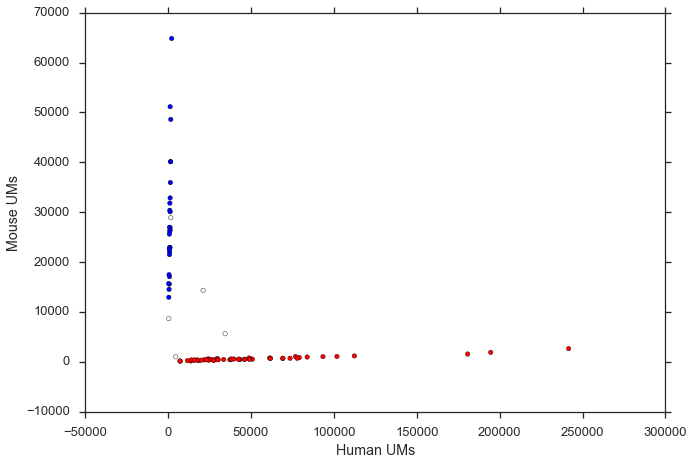

In [8]:
plt.scatter(Tfbc_group['human'],Tfbc_group['mouse'],c=1.0*np.array(Tfbc_group['human_lab']>0)-1.0*np.array(Tfbc_group['mouse_lab']>0),cmap='bwr')
plt.xlabel('Human UMs')
plt.ylabel('Mouse UMs')

In [9]:
#remove cross-species doublets
notdoublet=np.logical_or(Tfmerge['mouse_lab'],Tfmerge['human_lab'])
Tfmerge=Tfmerge[notdoublet]

#label mismatch molecules as ones that are genes from the opposite species
Tfmerge['mismatch']=np.logical_or(np.logical_and(Tfmerge['human']>0,Tfmerge['mouse_lab']),np.logical_and(Tfmerge['mouse']>0,Tfmerge['human_lab']))

In [10]:
Tfmerge_h=Tfmerge[Tfmerge['human']>0]
Tfmerge_m=Tfmerge[Tfmerge['mouse']>0]

In [11]:
np.sum(np.logical_and(Tfmerge['mismatch'],Tfmerge['human_lab']))

32014

In [12]:
np.sum(np.logical_and(Tfmerge['mismatch'],Tfmerge['mouse_lab']))

27230

In [13]:
np.sum(np.logical_not(Tfmerge['mismatch']))

3394611

In [63]:
#Calculate chimera probabilities based on observed abundances of human mouse cells and genes
hgsums=Tfmerge['human_lab'].sum()
mgsums=Tfmerge['mouse_lab'].sum()
hg=np.divide(1.0*hgsums,hgsums+mgsums)
hb=np.divide(1.0*hbcsums,hbcsums+mbcsums)
chimera_probs=pd.DataFrame([[hg*hb,hg*(1-hb)],[hb*(1-hg),(1-hb)*(1-hg)]])
chimera_probs.columns=['Human Cell','Mouse Cell']
chimera_probs.index=['Human Gene','Mouse Gene']
chimera_probs

,Human Cell,Mouse Cell
Human Gene,0.628846,0.148047
Mouse Gene,0.180591,0.042516


In [18]:
#gene level summary statistics
hprop=pd.read_csv(path2data+'/hg38geneprops.csv',index_col=0)
hprop['Gene']=hprop.index
mprop=pd.read_csv(path2data+'/mm10geneprops.csv',index_col=0)
mprop['Gene']=mprop.index

In [19]:
#add species level gene properties
Tfmerge_h=Tfmerge_h.join(hprop,on='Gene',rsuffix='_2')
Tfmerge_h=Tfmerge_h.dropna()
Tfmerge_m=Tfmerge_m.join(mprop,on='Gene',rsuffix='_2')
Tfmerge_m=Tfmerge_m.dropna()
Tfmerge_f=pd.concat([Tfmerge_h,Tfmerge_m])

In [20]:
Tfmerge_f['log(Reads)']=np.log2(Tfmerge_f['Num_Obs'])

In [21]:
def gc_calc(seq):
    seqlen=len(seq)
    gc=np.divide(1.0*(seq.count('G')+seq.count('C')),seqlen)
    return gc

#add gc content feature
Tfmerge_f['gccbc']=[gc_calc(x) for x in Tfmerge_f['Cell Barcode']]
Tfmerge_f['gcumi']=[gc_calc(x) for x in Tfmerge_f['Molecular_Barcode']]

In [41]:
#extract final sample labels and features

y=Tfmerge_f['mismatch']
X=Tfmerge_f[['log(Reads)','TPT','gccbc','gcumi','gsums','bcsums','Avg Length','Avg GC','Avg KPK']]

In [42]:
Xlog=X.copy()
Xlog['Avg Length']=np.log2(Xlog['Avg Length'])
Xlog['bcsums']=np.log2(Xlog['bcsums'])

In [43]:
rf=sklearn.ensemble.RandomForestClassifier(n_estimators=300,oob_score=True,n_jobs=-1,class_weight='auto',verbose=1)

In [44]:
#fit random forest
rf.fit(Xlog,y)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 13.9min finished


RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=True, random_state=None, verbose=1, warm_start=False)

In [45]:
probs=[(x[0]-x[1]) for x in rf.oob_decision_function_]

In [46]:
fprrf, tprrf, thresholds = sklearn.metrics.roc_curve(y,-np.array(probs))

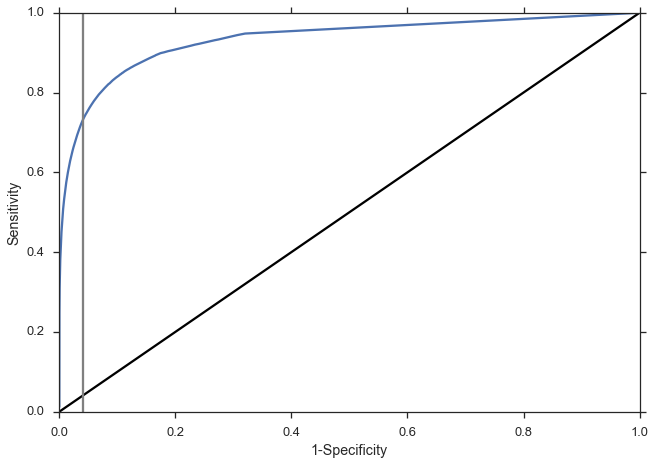

In [50]:
plt.plot(fprrf,tprrf,label='Random Forest')
plt.plot([0,1],[0,1],c='black')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.axvline(0.04,c='gray')

In [48]:
aucrf=sklearn.metrics.auc(fprrf,tprrf)
print('AUC is '+str(aucrf))
probthresh=thresholds[fprrf<fpr_threshold][-1]
prob_logical=-np.array(probs)<probthresh
print('Filtered '+str(np.round(100.0*(1.0-np.mean(prob_logical)),2))+'% of molecules')

AUC is 0.933610558166
Filtered 3.05% of molecules


In [49]:
df_rf=pd.DataFrame(rf.feature_importances_)
df_rf.index=X.columns
df_rf.sort_values(0,ascending=False)

,0
log(Reads),0.214529
gsums,0.147509
Avg Length,0.136966
Avg GC,0.133134
bcsums,0.123919
TPT,0.109936
Avg KPK,0.062631
gccbc,0.035955
gcumi,0.035422


In [ ]:
T_F=Tfmerge_f[prob_logical]
T_F['unique']=np.array([1.0]*len(T_F))
T_F['bcgene']=[(x,y) for x,y in zip(T_F['Cell Barcode'],T_F['Gene'])]
T_FF = T_F.groupby('bcgene').sum()

In [54]:
def str2index(strlist):
    reduced=pd.DataFrame(list(set(np.sort(strlist))))
    reduced=reduced.reset_index()
    reduced.index=reduced[0]
    dftmp=pd.DataFrame(strlist,index=strlist)
    dftmp=dftmp.merge(reduced,how='left')['index']
    return np.array(dftmp),list(reduced[0])

In [55]:
tfrow=[x[1] for x in T_FF.index]
tfrow,gnames=str2index(tfrow)
tfcol=[x[0] for x in T_FF.index]
tfcol,cnames=str2index(tfcol)
tfdata=np.array(T_FF['unique'])
tmpcol=pd.DataFrame(np.unique(tfcol))
tmpcol['unind']=range(len(tmpcol))

dftfcol=pd.DataFrame(tfcol)
dftfcol=dftfcol.merge(tmpcol,on=0)
tfcol=np.array(dftfcol['unind'])
EXPR_MAT=scipy.sparse.csr_matrix((tfdata,(tfrow,tfcol)),shape=(np.max(tfrow)+1,np.max(tfcol)+1)).toarray()
EXPR_MAT=pd.DataFrame(EXPR_MAT)
EXPR_MAT.index=gnames
EXPR_MAT.columns=cnames

In [56]:
#WARNING this matrix contains both human and mouse genes, but you can filter as needed
EXPR_MAT.head()

,ATCTTCGGATCA,TACAATTAAGGC,TTGCCTTACGCG,TCTGGATGCGCA,GGATACATGGTA,CACTCTGCAAGG,GAAGTTGGCGGA,AGACTTCCCTCG,AAGTAAGCAAGC,TGGCTATACCAA,...,CGCCCAGTACCG,GAGACTGCCCCA,GAATGGCATGCT,CCTAGACGTAGT,GACACTTCATCG,CGTGATGACCCT,AACCTATGGGCC,CCTTGTACTTTT,TGAATGTTTGAC,TCTCACAATGGG
Plekhg2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Plekhg3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plekhg4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Plekhg5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Nsa2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0


In [ ]:
EXPR_MAT.to_csv(outputpath+'/expr_mat_Yorimasafiltered.txt',sep='\t')